In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-72
totalMassInCU = 0.1
dtInCU = 4000.0
bigT = 20000

/home/kklee/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A2=  -0.3197640202007044  X= 20.65212130424261
A2=  -0.2846348092409239  X= 20.041480082960167
A2=  -0.2895628577599795  X= 16.828753657507317
A2=  -0.28933444795941166  X= 17.05139410278821
A2=  -0.28933444795941166  X= 17.05139410278821
MU= 1.1520406002672348 MASS= 0.09999899385360425
FAR POINT: 160876 500000


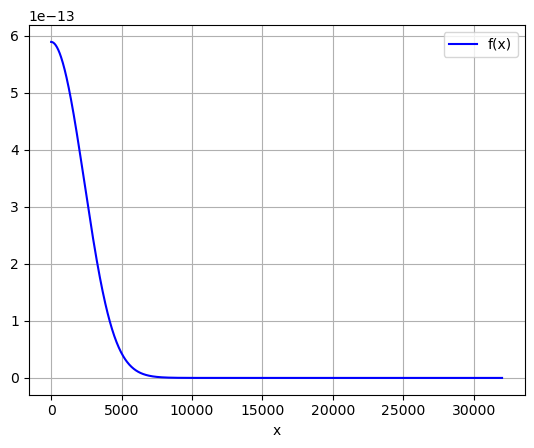

(850,)


In [2]:
allThings = outputProfile(massInCU, aInCU, totalMassInCU, 500)
#Hot Fix
x = allThings["x"][1::2]
psi = allThings["profile"][1::2]

dx = x[1]-x[0]
for i in range(600):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 1.2233182200635002e+41
Omega: 3.656129092998464e-44
Epsilon (Should be 1): 1.0000000000000002
Delta: 46.926491232498286
New G: 3.734291520805297


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
x = np.concatenate((np.flip(-x), x))

psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
psi = np.concatenate((np.flip(psi), psi))
normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
psi = psi/normalization
psi = psi.astype(complex)

'''
for index, value in enumerate(psi):
    if(value<1e-8):
        psi[index] = 0
psi = psi.astype(complex)
'''

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print(dt)

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
0.026723286841307287


In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T, TSph
    for i in range(size):
        if i==0:
            T[i][i] = -1.0
            T[i][i+1] = 1.0
            TSph[i][i+1] = 1.0/2.0/x[i] #What should it be?
            TSph[i][i] = -1.0/2.0/x[i]
        elif i==size-1:
            T[i][i] = -1.0
            T[i][i-1] = 1.0
            TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i] = 1.0/2.0/x[i]
        else:
            T[i][i] = -2.0
            T[i][i+1] = 1.0
            T[i][i-1] = 1.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]

    T = -1.0/2.0/dx/dx*T
    TSph = -1.0/dx*TSph

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i])*np.absolute(psi[i])

def setupV2Grav():
    global V2Grav, phi, psi

    rho = np.absolute(psi)[size//2:]*np.absolute(psi)[size//2:]
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi)[size//2:])
    my_func.findGravRho(rho_c, phi_c, c_int(size//2), c_double(dx))
    for i in range(size//2):
        place = int(size//2 + i)
        phi[place] = phi_c[i] * GM

    for i in range(size//2):
        V2Grav[i][i] = phi[size-i-1]
        V2Grav[size-i-1][size-i-1] = phi[size-i-1]
            
        phi[i] = phi[size-i-1] #Regulate

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+TSph+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+TSph+Q+V2Grav)

0 0.0 0.11886150360658529 1.0000136900867647
1 0.026723286841307287 0.1188640075069496 1.0000136910090631
2 0.05344657368261457 0.1188612466355479 1.000013689992112
3 0.08016986052392186 0.11886904337454963 1.0000136928640568
4 0.10689314736522915 0.1188729514039656 1.0000136943036588
5 0.13361643420653643 0.11888020026687564 1.0000136969740494
6 0.16033972104784372 0.11889204677316766 1.0000137013385055
7 0.187063007889151 0.11890191278192634 1.000013704973644
8 0.2137862947304583 0.11891771005705926 1.0000137107947902
9 0.24050958157176558 0.11893387359674217 1.000013716751702
10 0.26723286841307287 0.11895189379722897 1.0000137233938222
11 0.2939561552543801 0.11897417964655797 1.0000137316096225
12 0.32067944209568744 0.11899609535208554 1.0000137396904683
13 0.34740272893699475 0.11902224568211618 1.0000137493346692
14 0.374126015778302 0.11904983319101861 1.0000137595111966
15 0.40084930261960927 0.11907895058127425 1.0000137702546272
16 0.4275725894609166 0.1191117771325297 1.00

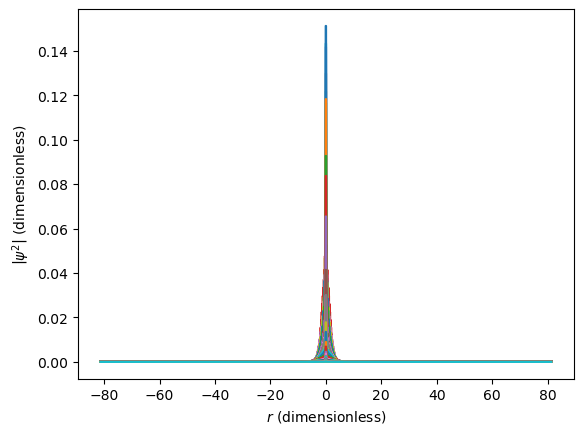

In [7]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()


#Record
gravitationalForce = []
pressureGradient = []
quantumPressure = []

hello = []
ts = []
oldGM = GM
newGM = GM*1.05
for t in range(bigT):
    #Pertubation
    if(t*dt<2.0):
        GM = newGM
    if(t*dt>=2.0):
        GM = oldGM

    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    #Regulate
    for i in range(size//2):
        psi[i] = psi[size-i-1]

    normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
    if(normalization >= 1.01):
        break
    print(t, t*dt, np.absolute(psi[size//2]), normalization)
    if(GM == oldGM):
        hello.append(np.absolute(psi[size//2])*np.absolute(psi[size//2]))
        ts.append(t*dt)

        #Record
        rho0 = (np.absolute(psi[size//2 + 14])*np.absolute(psi[size//2 + 14]))/Ra/Ra/Ra*totalMass
        rho1 = (np.absolute(psi[size//2 + 15])*np.absolute(psi[size//2 + 15]))/Ra/Ra/Ra*totalMass
        rho2 = (np.absolute(psi[size//2 + 16])*np.absolute(psi[size//2 + 16]))/Ra/Ra/Ra*totalMass
        rho3 = (np.absolute(psi[size//2 + 17])*np.absolute(psi[size//2 + 17]))/Ra/Ra/Ra*totalMass
        Q0 = -((np.sqrt(rho0) -2*np.sqrt(rho1) + np.sqrt(rho2))/(dx*Ra)/(dx*Ra) + 2.0/(x[size//2 + 15]*Ra)*(np.sqrt(rho1)-np.sqrt(rho0))/(dx*Ra))/np.sqrt(rho1)/2.0/m
        Q1 = -((np.sqrt(rho1) -2*np.sqrt(rho2) + np.sqrt(rho3))/(dx*Ra)/(dx*Ra) + 2.0/(x[size//2 + 16]*Ra)*(np.sqrt(rho2)-np.sqrt(rho1))/(dx*Ra))/np.sqrt(rho2)/2.0/m

        gravitationalForce.append((phi[size//2 + 16]-phi[size//2 + 15])/dx)
        pressureGradient.append(4.0*np.pi*a/m/m/m*(rho2-rho1)/(dx*Ra)/Ra/omegaA/omegaA)
        quantumPressure.append((Q1-Q0)/m/(dx*Ra)/Ra/omegaA/omegaA)

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

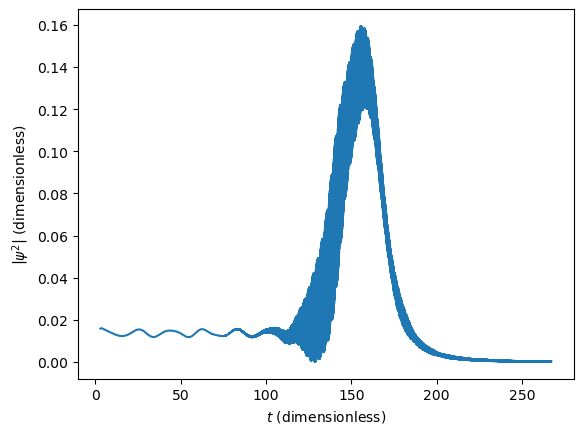

In [8]:
plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

Text(0.5, 0, 'f (1/s)')

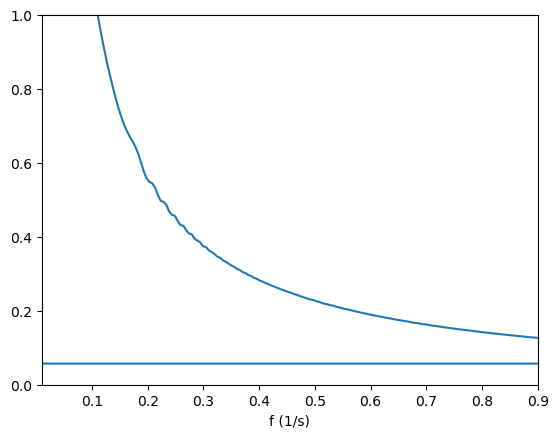

In [9]:
sp = np.fft.fft(hello[:5000])
freq = np.fft.fftfreq(len(hello[:5000]), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.9)
plt.ylim(0.0,1.0)
plt.xlabel("f (1/s)")

In [10]:
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.07 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.06598052499999998 1.6377734818772693
0.07613137499999999 1.5760875455803134
1.2739316749999998 0.08984262239747456
1.5733817499999996 0.07255814680524217
10.095020324999998 7.686307570501428


[7.60175455e-06 7.59909849e-06 7.56104274e-06 ... 7.56104274e-06
 7.59909849e-06 7.60175455e-06]


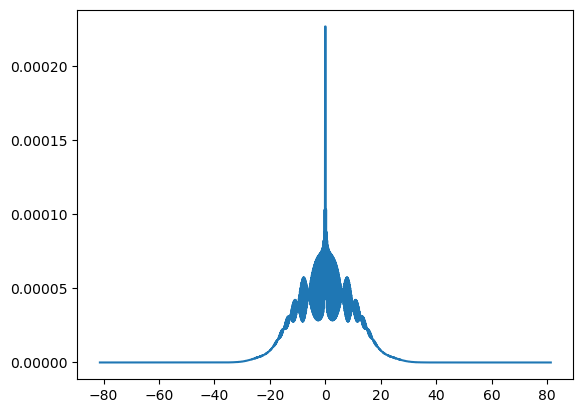

In [11]:
plt.plot(x, np.absolute(psi)*np.absolute(psi))
print(np.absolute(psi))

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?

In [12]:
print(psi)

[-7.15640196e-06-2.56370497e-06j -7.15345951e-06-2.56404270e-06j
 -7.13708656e-06-2.49626978e-06j ... -7.13708656e-06-2.49626978e-06j
 -7.15345951e-06-2.56404270e-06j -7.15640196e-06-2.56370497e-06j]
